# Music Composer Classification using Neural Network

# Team members:
1. Suman Senapati
2. Navyesh
3. Shruti A K

## Additional Libraries

In [41]:
!pip install tensorflow music21

## Libraries

In [53]:
# For data handling and visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from collections import Counter

# For data pre-processing
import os
import glob
from music21 import converter, instrument, note, chord

# For neural network building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import RMSprop

# For model weights saving
import pickle

## Configuration

In [43]:
warnings.filterwarnings('ignore')

## Dataset

Reads notes from music files

In [44]:
def get_notes_from_midi(file_path):
    notes = []
    try:
        from music21 import converter, note, chord
        midi = converter.parse(file_path)
        for element in midi.flat.notes:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    except Exception as e:
        print(f"Failed to parse {file_path}: {e}")
    return notes

#### Loads all MIDI files from the specified directory structure

In [45]:
def load_midi_files_by_composer(path, update_interval=30):
    composers = {}
    for composer_dir in os.listdir(path):
        composer_path = os.path.join(path, composer_dir)
        if os.path.isdir(composer_path):
            print(f"\nLoading files for {composer_dir}...")
            composer_files = []
            midi_files = glob.glob(os.path.join(composer_path, '*.mid*'))
            total_files = len(midi_files)
            loaded_files = 0

            for idx, file in enumerate(midi_files, 1):
                notes = get_notes_from_midi(file)
                if notes:
                    composer_files.append(notes)
                    loaded_files += 1

                if idx % update_interval == 0 or idx == total_files:
                    print(f"Processed {idx}/{total_files} files...")

            print(f"✓ Loaded {loaded_files}/{total_files} valid MIDI files for {composer_dir}.")
            composers[composer_dir] = composer_files
    return composers

## Data Preparation

In [46]:
def split_composer_data(composers_data, test_size=0.15, val_size=0.15):
    split_data = {'train': {}, 'val': {}, 'test': {}}
    for composer, songs in composers_data.items():
        train_val, test = train_test_split(songs, test_size=test_size, random_state=42)
        train, val = train_test_split(train_val, test_size=val_size / (1 - test_size), random_state=42)
        split_data['train'][composer] = train
        split_data['val'][composer] = val
        split_data['test'][composer] = test
    return split_data

#### Creates input sequences and corresponding outputs for the network.

In [47]:
def flatten_notes_per_composer(split_data_section):
    flattened = {}
    for composer, pieces in split_data_section.items():
        flattened[composer] = [note for piece in pieces for note in piece]
    return flattened

In [94]:
def prepare_sequences_safe(notes, note_to_int, seq_len=20):
    input_sequences = []
    for i in range(len(notes) - seq_len):
        seq_in = notes[i:i+seq_len]
        # skip sequence if any note is unknown
        if all(n in note_to_int for n in seq_in):
            input_sequences.append([note_to_int[n] for n in seq_in])
    return np.array(input_sequences), None

In [49]:
base_path='/kaggle/input/composer-dataset/'

In [50]:
composers_notes = load_midi_files_by_composer(base_path)


Loading files for Bach...
Processed 30/925 files...
Processed 60/925 files...
Processed 90/925 files...
Processed 120/925 files...
Processed 150/925 files...
Processed 180/925 files...
Processed 210/925 files...
Processed 240/925 files...
Processed 270/925 files...
Processed 300/925 files...
Processed 330/925 files...
Processed 360/925 files...
Processed 390/925 files...
Processed 420/925 files...
Processed 450/925 files...
Processed 480/925 files...
Processed 510/925 files...
Processed 540/925 files...
Processed 570/925 files...
Processed 600/925 files...
Processed 630/925 files...
Processed 660/925 files...
Processed 690/925 files...
Processed 720/925 files...
Processed 750/925 files...
Processed 780/925 files...
Processed 810/925 files...
Processed 840/925 files...
Processed 870/925 files...
Processed 900/925 files...
Processed 925/925 files...
✓ Loaded 925/925 valid MIDI files for Bach.

Loading files for Mozart...
Processed 30/257 files...
Processed 60/257 files...
Processed 90/2

In [8]:
split_data = split_composer_data(composers_notes)

In [2]:
train_flat = flatten_notes_per_composer(split_data['train'])
val_flat = flatten_notes_per_composer(split_data['val'])
test_flat = flatten_notes_per_composer(split_data['test'])

In [3]:
print({k: {comp: len(v) for comp, v in split_data[k].items()} for k in split_data})

{'train': {'Bach': 647, 'Mozart': 179, 'Beethoven': 149, 'Chopin': 94}, 'val': {'Bach': 139, 'Mozart': 39, 'Beethoven': 32, 'Chopin': 21}, 'test': {'Bach': 139, 'Mozart': 39, 'Beethoven': 32, 'Chopin': 21}}


In [81]:
all_notes = []
for notes in composers_notes.values():
    for n in notes:
        all_notes.append(n)

len(all_notes)

1531

In [84]:
flat_notes = [note for sublist in all_notes for note in sublist]

In [85]:
flat_notes[:5]

['C#5', 'A4', 'E4', 'A2', 'A4']

In [86]:
note_names = sorted(set(flat_notes))
note_to_int = {note: num for num, note in enumerate(note_names)}
int_to_note = {num: note for note, num in note_to_int.items()}

In [51]:
train_in, train_out = prepare_sequences(train_flat, note_to_int)
val_in, val_out = prepare_sequences(val_flat, note_to_int)
test_in, test_out = prepare_sequences(test_flat, note_to_int)

In [52]:
composer_to_int = {composer: i for i, composer in enumerate(train_flat.keys())}
int_to_composer = {i: composer for composer, i in composer_to_int.items()}
n_composers = len(composer_to_int)

In [53]:
print(f"Number of composers in train_flat: {len(train_flat)}")
for composer, notes in train_flat.items():
    print(f"{composer}: {len(notes)} notes")

Number of composers in train_flat: 4
Bach: 989654 notes
Mozart: 801938 notes
Beethoven: 882062 notes
Chopin: 149966 notes


In [145]:
train_in = []
train_out = []
val_in = []
val_out = []
test_in = []
test_out = []

In [146]:
total_seqs = 0
for composer, notes in train_flat.items():
    input_seq, _ = prepare_sequences_safe(notes, note_to_int)
    print(f"{composer}: {len(input_seq)}")
    total_seqs += len(input_seq)
    train_in.append(input_seq)
    train_out.extend([composer_to_int[composer]] * len(input_seq))

print("Total input sequences:", total_seqs)
print("Total output labels:", len(train_out))

Bach: 989634
Mozart: 801918
Beethoven: 882042
Chopin: 149946
Total input sequences: 2823540
Total output labels: 2823540


In [147]:
list(set(train_out))

[0, 1, 2, 3]

In [148]:
train_in = np.concatenate(train_in, axis=0)
print("Shape after concatenation:", train_in.shape)
train_out = np.array(train_out)
print("Final output shape:", train_out.shape)

Shape after concatenation: (2823540, 20)
Final output shape: (2823540,)


In [149]:
total_seqs = 0
for composer, notes in val_flat.items():
    input_seq, _ = prepare_sequences_safe(notes, note_to_int)
    print(f"{composer}: {len(input_seq)}")
    total_seqs += len(input_seq)
    val_in.append(input_seq)
    val_out.extend([composer_to_int[composer]] * len(input_seq))

print("Total input sequences:", total_seqs)
print("Total output labels:", len(val_out))

Bach: 184664
Mozart: 162452
Beethoven: 225368
Chopin: 27941
Total input sequences: 600425
Total output labels: 600425


In [150]:
val_in = np.concatenate(val_in, axis=0)
print("Shape after concatenation:", val_in.shape)
val_out = np.array(val_out)
print("Final output shape:", val_out.shape)

Shape after concatenation: (600425, 20)
Final output shape: (600425,)


In [151]:
total_seqs = 0
for composer, notes in test_flat.items():
    input_seq, _ = prepare_sequences_safe(notes, note_to_int)
    print(f"{composer}: {len(input_seq)}")
    total_seqs += len(input_seq)
    test_in.append(input_seq)
    test_out.extend([composer_to_int[composer]] * len(input_seq))

print("Total input sequences:", total_seqs)
print("Total output labels:", len(test_out))

Bach: 215184
Mozart: 196943
Beethoven: 159206
Chopin: 30447
Total input sequences: 601780
Total output labels: 601780


In [152]:
test_in = np.concatenate(test_in, axis=0)
print("Shape after concatenation:", test_in.shape)
test_out = np.array(test_out)
print("Final output shape:", val_out.shape)

Shape after concatenation: (601780, 20)
Final output shape: (600425,)


## Data Visualizations

In [104]:
# Convert to numpy arrays if not already
train_input = np.array(train_in)
train_output = np.array(train_out)

# Check shapes
print("train_input shape:", train_input.shape)
print("train_output shape:", train_output.shape)

# Print first 5 rows
print("\nFirst 5 rows of train_input:")
for i in range(5):
    print(train_input[i])

print("\nFirst 5 elements of train_output:")
print(train_output[:5])


train_input shape: (2823540, 20)
train_output shape: (2823540,)

First 5 rows of train_input:
[1112 1082 1158 1157 1159 1112 1082 1158 1075 1112 1074 1134 1083 1112
 1158 1158 1075 1112 1134 1111]
[1082 1158 1157 1159 1112 1082 1158 1075 1112 1074 1134 1083 1112 1158
 1158 1075 1112 1134 1111 1159]
[1158 1157 1159 1112 1082 1158 1075 1112 1074 1134 1083 1112 1158 1158
 1075 1112 1134 1111 1159 1082]
[1157 1159 1112 1082 1158 1075 1112 1074 1134 1083 1112 1158 1158 1075
 1112 1134 1111 1159 1082 1158]
[1159 1112 1082 1158 1075 1112 1074 1134 1083 1112 1158 1158 1075 1112
 1134 1111 1159 1082 1158 1118]

First 5 elements of train_output:
[0 0 0 0 0]


#### Counting number of MIDI files for each composer in a given directory

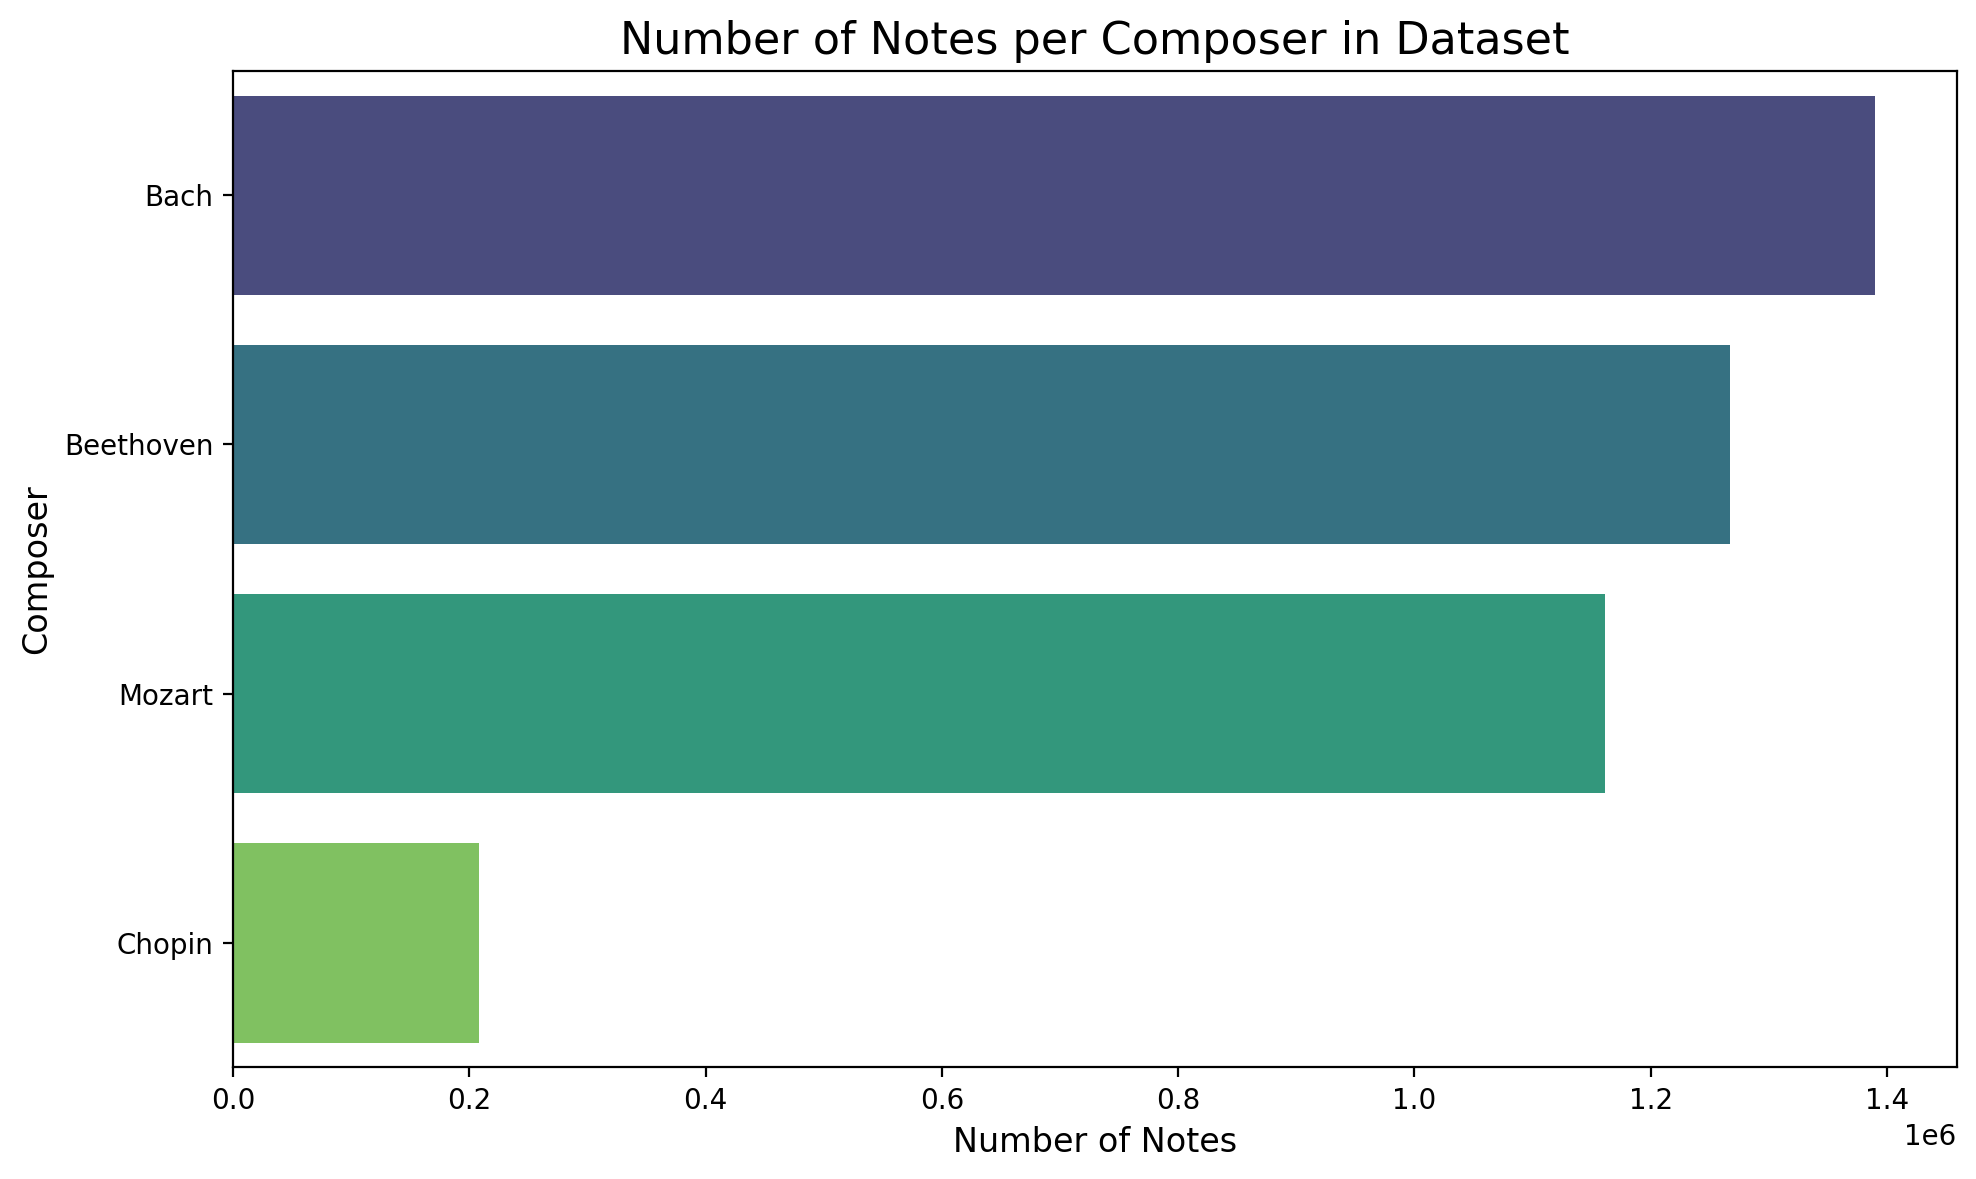

In [105]:
from collections import Counter

train_counts = Counter({composer: len(notes) for composer, notes in train_flat.items()})
val_counts = Counter({composer: len(notes) for composer, notes in val_flat.items()})
test_counts = Counter({composer: len(notes) for composer, notes in test_flat.items()})

# Combine counts
total_counts = train_counts + val_counts + test_counts

# Prepare a DataFrame for plotting
df_counts = pd.DataFrame({
    'Composer': list(total_counts.keys()),
    'Note Count': list(total_counts.values())
}).sort_values('Note Count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sn.barplot(x='Note Count', y='Composer', data=df_counts, palette='viridis')
plt.title('Number of Notes per Composer in Dataset', fontsize=16)
plt.xlabel('Number of Notes', fontsize=12)
plt.ylabel('Composer', fontsize=12)
plt.tight_layout()
plt.show()

#### Note & Chord Distribution

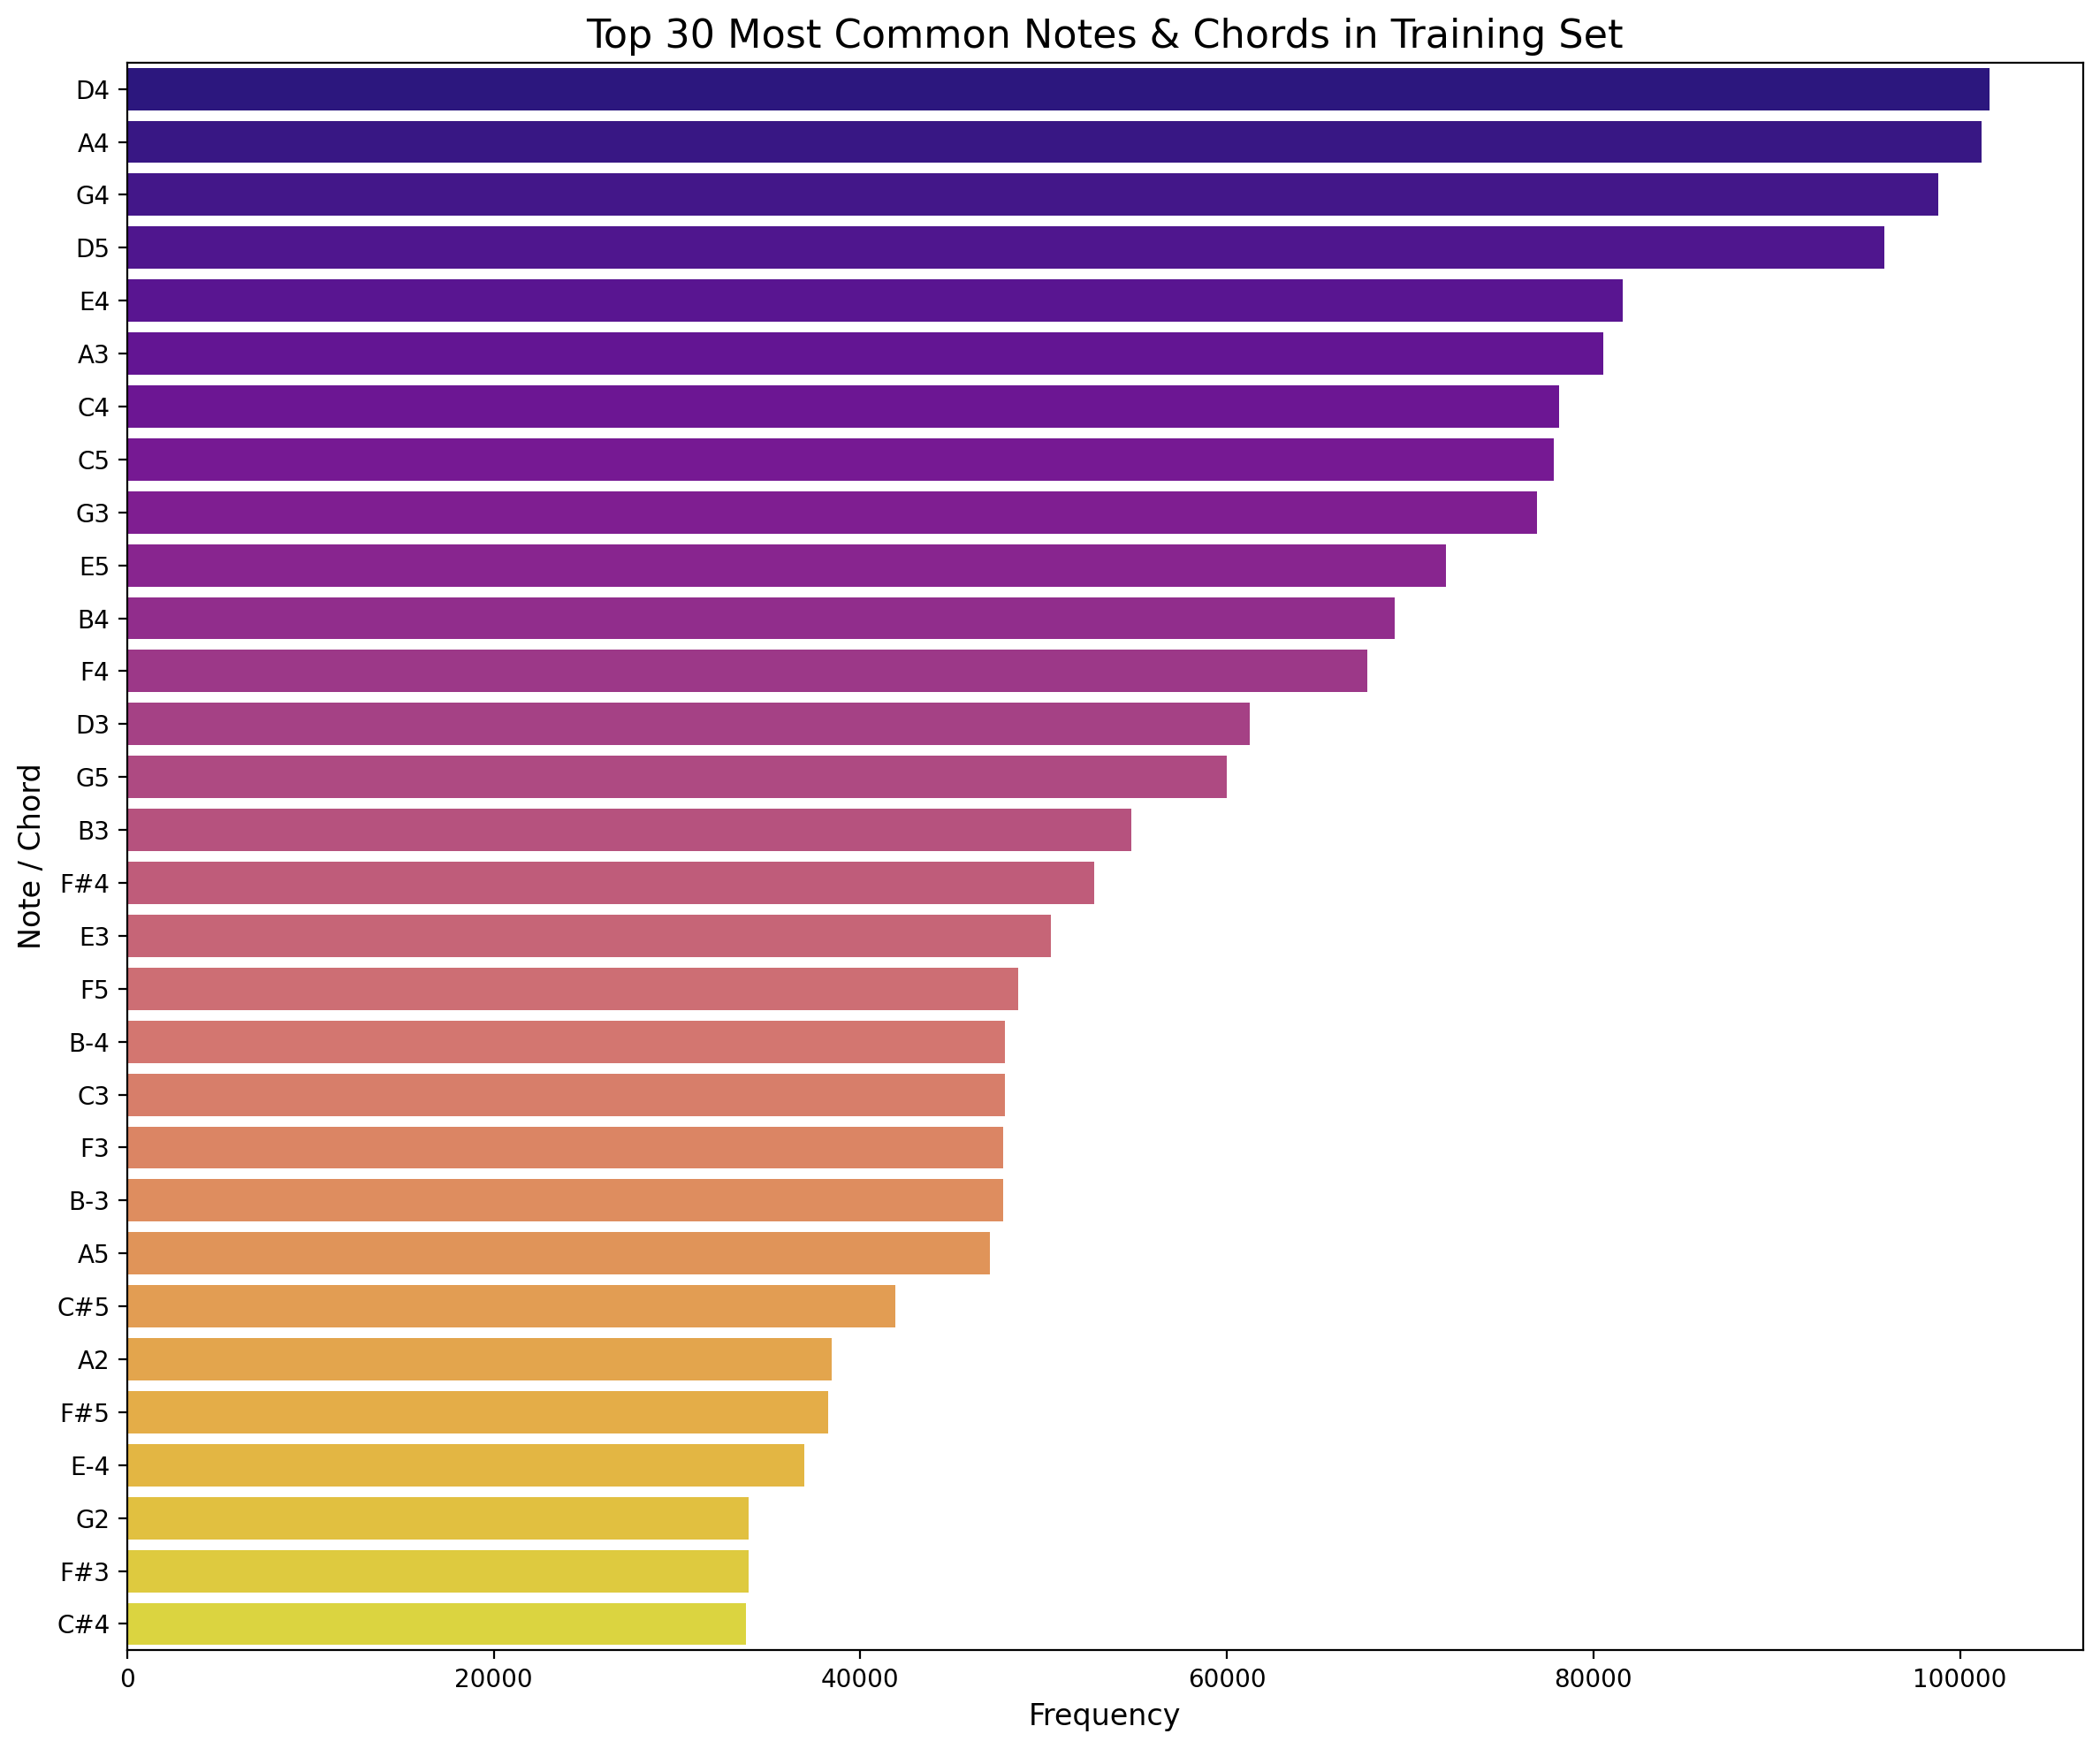

In [106]:
all_elements = [element for notes_list in train_flat.values() for element in notes_list]

# Count frequency of each note/chord
element_counts = Counter(all_elements)
most_common_elements = element_counts.most_common(30)

# Create DataFrame for plotting
df_elements = pd.DataFrame(most_common_elements, columns=['Element', 'Count'])

# Plot
plt.figure(figsize=(12, 10))
sn.barplot(x='Count', y='Element', data=df_elements, palette='plasma', orient='h')
plt.title('Top 30 Most Common Notes & Chords in Training Set', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Note / Chord', fontsize=12)
plt.tight_layout()
plt.show()

#### Distribution of Musical Piece Lengths

## Model Building

In [107]:
y_train = np.array(train_out)


weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(weights))

In [54]:
model = Sequential()

# 🔹 More powerful convolutional front-end
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(20, 1)))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# 🔹 Deeper LSTM layers
model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(32, dropout=0.3))

# 🔹 Dense + Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# 🔹 Output layer
model.add(Dense(n_composers, activation='softmax'))

#### Model compilation

In [41]:
optimizer = RMSprop(learning_rate=0.001)

In [55]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 20, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,452 (1001.77 KB)

 Trainable params: 256,196 (1000.77 KB)

 Non-trainable params: 256 (1.00 KB)

## Model Training

In [56]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

In [31]:
assert train_in.shape[0] == train_out.shape[0]
assert val_in.shape[0] == val_out.shape[0]

In [32]:
print(train_in.shape)   # Should be (num_samples, sequence_length, 1)
print(train_out.shape)  # Should be (num_samples,) or (num_samples, n_classes) if one-hot
print(np.unique(train_out))  # Should be [0, 1, 2, 3]
print(train_out.dtype) 

(2823540, 20, 1)
(2823540,)
[0 1 2 3]
int64


In [33]:
train_in = train_in.reshape((train_in.shape[0], train_in.shape[1], 1))
val_in = val_in.reshape((val_in.shape[0], val_in.shape[1], 1))

In [59]:
history = model.fit(
        train_in, train_out,
        epochs=10,
        batch_size=256,
        validation_data=(val_in, val_out),
        callbacks=callbacks,
        class_weight=class_weight
    )

Epoch 1/10
11030/11030 ━━━━━━━━━━━━━━━━━━━━ 596s 54ms/step - accuracy: 0.3769 - loss: 1.2566 - val_accuracy: 0.4002 - val_loss: 1.2254 - learning_rate: 0.0010
Epoch 2/10
11030/11030 ━━━━━━━━━━━━━━━━━━━━ 610s 55ms/step - accuracy: 0.4071 - loss: 1.2109 - val_accuracy: 0.3782 - val_loss: 1.2460 - learning_rate: 0.0010
Epoch 3/10
11030/11030 ━━━━━━━━━━━━━━━━━━━━ 627s 57ms/step - accuracy: 0.4200 - loss: 1.1845 - val_accuracy: 0.4129 - val_loss: 1.2054 - learning_rate: 0.0010
Epoch 4/10
11030/11030 ━━━━━━━━━━━━━━━━━━━━ 612s 55ms/step - accuracy: 0.4285 - loss: 1.1717 - val_accuracy: 0.4455 - val_loss: 1.1616 - learning_rate: 0.0010
Epoch 5/10
11030/11030 ━━━━━━━━━━━━━━━━━━━━ 610s 55ms/step - accuracy: 0.4340 - loss: 1.1624 - val_accuracy: 0.4043 - val_loss: 1.2060 - learning_rate: 0.0010
Epoch 6/10
11030/11030 ━━━━━━━━━━━━━━━━━━━━ 609s 55ms/step - accuracy: 0.4367 - loss: 1.1544 - val_accuracy: 0.4376 - val_loss: 1.1570 - learning_rate: 0.0010
Epoch 7/10
11030/11030 ━━━━━━━━━━━━━━━━━━━━ 61

## Model Evaluation

In [61]:
y_pred_probs = model.predict(test_in)
y_pred = np.argmax(y_pred_probs, axis=1)

y_test_labels = test_out

target_names = [name for name, num in sorted(composer_to_int.items(), key=lambda item: item[1])]

weighted_f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"\nWeighted F1-Score: {weighted_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

18806/18806 ━━━━━━━━━━━━━━━━━━━━ 180s 10ms/step

Weighted F1-Score: 0.4470

Detailed Classification Report:
              precision    recall  f1-score   support

        Bach       0.60      0.61      0.61    215184
      Mozart       0.49      0.37      0.42    196943
   Beethoven       0.49      0.22      0.30    159206
      Chopin       0.14      0.74      0.23     30447

    accuracy                           0.44    601780
   macro avg       0.43      0.49      0.39    601780
weighted avg       0.51      0.44      0.45    601780



## Saving Model weights

In [62]:
model.save('composer_classification_model.h5')
    
with open('mappings.pkl', 'wb') as f:
    pickle.dump({'note_to_int': note_to_int, 'composer_to_int': composer_to_int}, f)
        
print("Save completed")

Save completed
